In [ ]:
import os
import shutil
import subprocess
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
import seaborn as sns

# (This is for me, so I don't forget to add it to the conda environment)
# conda install matplotlib scipy
# conda install scikit-learn
# conda install seaborn

In [51]:
# Global Variables
DATA_DIR = 'data'
GENOME_SOURCE_DIR = '/proj/SIUE-CS590-490/reference'
GENOME_OUTPUT_DIR = 'data/reference_genome'
DOWNLOAD_DIR = 'data/zip_files'
POS_BED_FILE_DIR = 'data/positive_bed_files'
NEG_BED_FILE_DIR = 'data/negative_bed_files'
POS_TXT_DIR = 'data/positive_txt_files'
NEG_TXT_DIR = 'data/negative_txt_files'
POS_NUCLEO_DIR = 'data/positive_nucleo_file'
NEG_NUCLEO_DIR = 'data/negative_nucleo_file'
POS_NUCLEO_FILE = 'data/positive_nucleo_file/P_NUCLEOTIDES.txt'
NEG_NUCLEO_FILE = 'data/negative_nucleo_file/N_NUCLEOTIDES.txt'
MERGED_NUCLEO_FILE = 'data/merged_nucleo_file/M_NUCLEOTIDES.txt'
C_POS_NUCLEO_FILE = 'data/positive_nucleo_file/CP_NUCLEOTIDES.txt'
C_NEG_NUCLEO_FILE = 'data/negative_nucleo_file/CN_NUCLEOTIDES.txt'

CLASSES= 2
BATCH_SIZE = 32
seed=42
EPOCHS=5


DIVIDER = "-"*150
NEWLINE = "\n"

In [52]:
def create_directories(source_dir):
    print(DIVIDER)
    print("Creating appropriate directories for data collection")
    print(DIVIDER)

    # List of subdirectories to create
    subdirectories = ["reference_genome", "zip_files", "positive_bed_files", "negative_bed_files", "positive_txt_files", "negative_txt_files", "positive_nucleo_file", "negative_nucleo_file", "merged_nucleo_file"]

    # Loop through each subdirectory and create it if it doesn't exist
    for subdir in subdirectories:
        dir_path = os.path.join(source_dir, subdir)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")
        else:
            print(f"Directory already exists: {dir_path}")

    print(NEWLINE)

In [53]:
def copy_reference_genome(source_dir, dest_dir):
    print(DIVIDER)
    print("Copying Reference Genome")
    print(DIVIDER)

    # Ensure the source directory exists
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exists.")
        return
    
    # Ensure the destination directory exists, if not, create it
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)


    # Copy all files from source to destination
    for filename in os.listdir(source_dir):
        source_file = os.path.join(source_dir,filename)
        dest_file = os.path.join(dest_dir,filename)

        # Check if it's a file before copying
        if os.path.isfile(source_file):
            # Check if the file already exists in the destination directory
            if not os.path.exists(dest_file):
                shutil.copy(source_file, dest_dir)
                print(f"Copied {filename} to {dest_dir}")
            else:
                print(f"File {filename} already exists in the destination directory, skipping.")
                
    print(NEWLINE)

In [54]:
def download_files(dest_dir):
    print(DIVIDER)
    print("Downlaoding DNase-seq data")
    print(DIVIDER)
    
    #List of URLS to download
    urls = [
        "https://www.encodeproject.org/files/ENCFF677GRU/@@download/ENCFF677GRU.bed.gz",
        "https://www.encodeproject.org/files/ENCFF922ABK/@@download/ENCFF922ABK.bed.gz",
        "https://www.encodeproject.org/files/ENCFF524ZRE/@@download/ENCFF524ZRE.bed.gz",
        "https://www.encodeproject.org/files/ENCFF083WON/@@download/ENCFF083WON.bed.gz",
        "https://www.encodeproject.org/files/ENCFF041GGN/@@download/ENCFF041GGN.bed.gz",
        "https://www.encodeproject.org/files/ENCFF180WXO/@@download/ENCFF180WXO.bed.gz",
        "https://www.encodeproject.org/files/ENCFF076EKB/@@download/ENCFF076EKB.bed.gz",
        "https://www.encodeproject.org/files/ENCFF762IIH/@@download/ENCFF762IIH.bed.gz",
        "https://www.encodeproject.org/files/ENCFF985UCI/@@download/ENCFF985UCI.bed.gz",
        "https://www.encodeproject.org/files/ENCFF581DQN/@@download/ENCFF581DQN.bed.gz",
    ]

    # Ensure the destination directory exists
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Loop through each URL and download the corresponding file
    for url in urls:
        filename = url.split('/')[-1] # Get the filename from the URL
        dest_file = os.path.join(dest_dir, filename)

        # Check if the file already exists to avoid re-downloading
        if not os.path.exists(dest_file):
           print(f"Downloading {filename}...")
           subprocess.run(["wget", "-O", dest_file, url])
           print(f"Downloaded {filename} to {dest_file}")
        else:
           print(f"File {filename} already exists, skipping download.")

    print(NEWLINE)

In [55]:
def unzip_files(zip_dir, bed_dir):
    print(DIVIDER)
    print("Unzipping DNase-seq data")
    print(DIVIDER)

    # Ensure the bed directory exists
    if not os.path.exists(bed_dir):
        os.makedirs(bed_dir)

    # Loop through each .bed.gz file in the zip_dir
    for filename in os.listdir(zip_dir):
        if filename.endswith('.bed.gz'):
            zip_file = os.path.join(zip_dir, filename)
            bed_file = os.path.join(bed_dir, "P_" + filename.replace('.gz', ''))  # Remove .gz extension

            # Check if the .bed file already exists to avoid overwriting
            if not os.path.exists(bed_file):
                print(f"Unzipping {filename}...")
                subprocess.run(['gunzip', '-c', zip_file], stdout=open(bed_file, 'wb'))
                print(f"Unzipped {filename} to {bed_file}")
            else:
                print(f"File {bed_file} already exists, skipping unzip.")
                
    print(NEWLINE)


In [56]:
def convert_to_nucleotides(bed_dir, dest_dir):
    print(DIVIDER)
    print("Converting Bed files to Nucleotides")
    print(DIVIDER)

    # Ensure the bed directory exists
    if not os.path.exists(bed_dir):
        print(f"bed directory {bed_dir} does not exists.")
        return

    # Ensure the destniation directory exists
    if not os.path.exists(dest_dir):
        print(f"destination directory {dest_dir} does not exists.")
        return

    # Loop through each .bed file in the bed_dir
    for filename in os.listdir(bed_dir):
        new_filename = filename.replace(".bed", ".txt")

        
        bed_file = os.path.join(bed_dir, filename)
        genome_file = os.path.join(GENOME_OUTPUT_DIR, "hg38.fa")
        txt_file = os.path.join(dest_dir, new_filename)

        # Check if the .txt file already exists to avoid overwriting
        if not os.path.exists(txt_file):
            print(f"Converting {filename} to {new_filename}...")

            command = [
                'bedtools', 'getfasta',
                '-fi', genome_file,
                '-bed', bed_file,
                '-fo', txt_file
            ]

            subprocess.run(command, check=True)

            print(f"file {new_filename} to {dest_dir}")
        else:
            print(f"File {txt_file} already exists, skipping conversion.")
            
    print(NEWLINE)
        

In [57]:
def plot_gaussian(differences):
    # Convert differences list to a numpy array
    differences = np.array(differences)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(differences, bins=30, density=True, alpha=0.6, color='g', label='Differences')

    # Fit a Gaussian distribution to the data
    mean, std_dev = stats.norm.fit(differences)
    #print(math.floor(mean))

    # Plot the Gaussian fit
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)
    plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian fit: mean = {mean:.2f}, std dev = {std_dev:.2f}')

    # Add labels and title
    plt.xlabel('Difference (third - second)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Gaussian Distribution of Differences', fontsize=14)
    plt.legend(loc='best')

    # Show plot
    #plt.show()

    return math.floor(mean)

In [58]:
def find_optimal_length(nucleo_dir):
    print(DIVIDER)
    print("Finding the Optimal Nucleotide Length")
    print(DIVIDER)

    #lengths = []
    differences = []

    # Loop through each .txt file in the nucleo_dir
    for filename in os.listdir(nucleo_dir):
        file_path = os.path.join(nucleo_dir, filename)
        #print(filename)
        
        # Open the file in read mode
        #file = open(file_path, "r", encoding="utf-8-sig", errors="ignore")

        with open(file_path, "r", encoding="utf-8-sig", errors="ignore") as file:
            # Process each line in the file
            for line in file:
                #split the line by tab characters
                columns = line.split("\t")

                if len(columns) >= 3:
                    try:
                        # Extract the second and third columns (index 1 and 2)
                        second_column = int(columns[1])
                        third_column = int(columns[2])

                        # Perform the subtraction (third-second) and store the result
                        difference = third_column - second_column
                        #lengths.append([columns[0], columns[1], columns[2]])
                        differences.append(difference)
                    except ValueError:
                        # If there is a non-numeric value in the second or third column, skip it
                            continue

    # Plotting the differences
    mean = plot_gaussian(differences)
    print(f"After fitting the data to a guassaion curve the optimal length is {mean}. All sequences greater than or equal to this length will be kept, anything smaller than this number will be removed.")
    print(NEWLINE)
    return int(mean)
        


In [59]:
def crop_sequences(source_dir, dest_dir, opt_length):
    print(DIVIDER)
    print("Cropping and or removing Nucleotide Sequences")
    print(DIVIDER)

    if "positive" in dest_dir:
        output_file_path = os.path.join(dest_dir, "P_NUCLEOTIDES.txt")
    else:
        output_file_path = os.path.join(dest_dir, "N_NUCLEOTIDES.txt")

    # Ensure the source directory exists
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exists.")
        print(NEWLINE)
        return

    # Ensure the destniation directory exists
    if not os.path.exists(dest_dir):
        print(f"destination directory {dest_dir} does not exists.")
        print(NEWLINE)
        return
    
    for filename in os.listdir(source_dir):
        input_file_path = os.path.join(source_dir, filename)
        #print(f"Processing {filename}...")

        # Check if the .txt file in the dest_dir
        if not os.path.exists(output_file_path):
            with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
                lines = infile.readlines() # Read all lines
                for i in range(0, len(lines), 2): # Iterate in steps of 2 (header, sequence)
                    header = lines[i].strip()
                    sequence = lines[i + 1].strip()

                    if len(sequence) >= opt_length:
                        # if the seqeunce is longer than the desired length, trim it
                        trimmed_seqence = sequence[:opt_length]

                        # Write to the output file
                        outfile.write(f"{trimmed_seqence}\n")
        else:
            print(f"File {output_file_path} already exists, skipping cropping.")
            break
    
    print(NEWLINE)


    

In [98]:
def create_negative_bed_files(source_dir, dest_dir):
    print(DIVIDER)
    print("Creating Negative Bed files")
    print(DIVIDER)

    # Ensure the source directory exists
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exist.")
        print(NEWLINE)
        return

    # Ensure the destination directory exists
    if not os.path.exists(dest_dir):
        print(f"Destination directory {dest_dir} does not exist.")
        print(NEWLINE)
        return

    # Process files in the source directory
    for filename in os.listdir(source_dir):
        file_path = os.path.join(source_dir, filename)
        new_filename = filename.replace("P_", "N_")
        new_file_path = os.path.join(dest_dir, new_filename)
        
        if not os.path.exists(new_file_path):
            with open(file_path, 'r') as infile, open(new_file_path, 'w') as outfile:
                lines = infile.readlines()  # Read all lines
                for i in range(1, len(lines), 2):  # Iterate in steps of 2
                    try:
                        # Get sequence data
                        seq_one = lines[i - 1].strip()
                        seq_two = lines[i].strip()

                        # Split the line by tab characters
                        columns_one = seq_one.split("\t")
                        columns_two = seq_two.split("\t")

                        # Check if each sequence has the expected number of columns (at least 3)
                        if len(columns_one) < 3 or len(columns_two) < 3:
                            print(f"Skipping malformed line: {seq_one} or {seq_two}")
                            continue

                        chromosome_one = columns_one[0].strip()
                        chromosome_two = columns_two[0].strip()

                        start = int(columns_one[2].strip()) + 1  # Convert to 1-based indexing
                        end = int(columns_two[1].strip()) - 1  # Exclusive end

                        # Prepare the negative BED line
                        negative_line = f"{chromosome_one}\t{start}\t{end}"

                        # Only write if chromosomes match and start/end are not consecutive
                        if chromosome_one == chromosome_two and (start < end):
                            outfile.write(f"{negative_line}\n")

                    except ValueError as e:
                        # Print the specific line and error message
                        print(f"Error processing line: {lines[i-1]} {lines[i]}")
                        print(f"Error: {e}")
                        continue
        else:
             print(f"File {new_filename} already exists, skipping create.")
                
    print(NEWLINE)

In [97]:
def prepare_positive_file(pos_nucleo_file, output_file):
    print(DIVIDER)
    print("Adding Labels to positive nucleotide file")
    print(DIVIDER)

    if not os.path.exists(pos_nucleo_file):
        print(f"File {pos_nucleo_file} does not exist.")
        print(NEWLINE)
        return
    
    if os.path.exists(output_file):
        print(f"File {output_file} already exists skipping computation")
        return
    
    temp_file = open(output_file, 'w')

    with open(pos_nucleo_file) as file:
        # Read each line in the file
        for line in file:
            # write each line to a temp file
            upper_line = line.strip().upper()
            temp_file.write(upper_line+" 1\n")

    temp_file.close()

    print("Postive nucleotide file has been prepared for the model. (i.e. labels attached & to uppercase)")
    print(NEWLINE)    

In [96]:
def prepare_negative_file(neg_nucleo_file, output_file):
    print(DIVIDER)
    print("Adding Labels to negative nucleotide file")
    print(DIVIDER)

    if not os.path.exists(neg_nucleo_file):
        print(f"File {neg_nucleo_file} does not exist.")
        print(NEWLINE)
        return
    
    if os.path.exists(output_file):
        print(f"File {output_file} already exists skipping computation")
        return

    temp_file = open(output_file, 'w')

    with open(neg_nucleo_file) as file:
        # Read each line in the file
        for line in file:
            # write each line to a temp file
            upper_line = line.strip().upper()
            temp_file.write(upper_line+" 0\n")

    temp_file.close()

    print("Negative nucleotide file has been prepared for the model. (i.e. labels attached & to uppercase)")
    print(NEWLINE)

In [99]:
def interleave_merge_files(positive_file, negative_file, output_file):
    print(DIVIDER)
    print("Interleaving positive and negative nucleotide files.")
    print(DIVIDER)

    # If the merged file already exists, skip merging to avoid overwriting
    if os.path.exists(output_file):
        print(f"File {output_file} already exists skipping computation.")
        print(NEWLINE)
        return

    # Open all three files: positive, negative, and the output file for writing
    with open(positive_file, 'r') as pos_f, open(negative_file, 'r') as neg_f, open(output_file, 'w') as out_f:
        while True:
            # Read one line at a time from each file
            pos_line = pos_f.readline()
            neg_line = neg_f.readline()

            # Stop if either file has no more lines
            if not pos_line or not neg_line:
                break

            # Write one line from each file to the output, alternating
            out_f.write(pos_line)
            out_f.write(neg_line)

        # One file has ended; write one more line from the file that still has data
        if pos_line and not neg_line:
            out_f.write(pos_line)
        elif neg_line and not pos_line:
            out_f.write(neg_line)

    print(f"The merged file has been successfully created located at: {output_file}")
    print(NEWLINE)

In [100]:
def one_hot_encode(sequence):
    # Mapping for each nucleotide to a one-hot encoded vector
    mapping = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]   # 'N' is used for unknown bases
    }
    # Apply the mapping for each base in the sequence
    return np.array([mapping[base] for base in sequence])


In [101]:
def load_data(file_path):
    sequences, labels = [], []

    # Read each line from the file
    with open(file_path) as f:
        for line in f:
            parts = line.strip().split()             # Each line should be: <sequence> <label>
            seq, label = parts[0], int(parts[1])
            onehot = one_hot_encode(seq)             # One-hot encode the sequence
            sequences.append(onehot)
            labels.append(label)

    # Convert lists to numpy arrays, then to PyTorch tensors
    sequences = np.array(sequences)
    labels = np.array(labels)

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [102]:
# Custom dataset class for PyTorch that wraps DNA sequences and labels
class DNADataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)  # Return the number of samples

    def __getitem__(self, idx):
        # Return a single sample (sequence and its label)
        return self.sequences[idx], self.labels[idx]

In [103]:
def split_dataset(dataset, train_ratio=0.8):
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)  # Calculate training set size
    test_size = total_size - train_size         # Remaining goes to test set
    return random_split(dataset, [train_size, test_size])

# ALEXNET

In [104]:
class AlexNet(nn.Module):
    def __init__(self, fc_units=4096):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=96,kernel_size=11,stride=4)
        self.local_response1=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv2 = nn.Conv1d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
        self.local_response2=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2)
        self.pool2=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv3=nn.Conv1d(in_channels=256,out_channels=384,kernel_size=3,padding=1)
        self.conv4=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=3,padding=1)
        self.conv5=nn.Conv1d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        self.pool5=nn.MaxPool1d(kernel_size=3,stride=2)

        self.fc1 = nn.Linear(in_features=(256*5),out_features=fc_units)
        self.fc2 = nn.Linear(in_features=fc_units,out_features=fc_units)
        self.fc3 = nn.Linear(in_features=fc_units,out_features=CLASSES)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool1(F.relu(self.local_response1(self.conv1(x))))
        x = self.pool2(F.relu(self.local_response2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool5(F.relu(self.conv5(x)))

        # Print the size of x before flattening
        #print(x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

# Assignment 2 (Program 2)

In [105]:
class Program_2(nn.Module):
    def __init__(self, fc_units=1024):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=96,kernel_size=11,stride=4, padding=0)
        self.conv2 = nn.Conv1d(in_channels=96,out_channels=96,kernel_size=1)
        self.conv3=nn.Conv1d(in_channels=96,out_channels=96,kernel_size=1)
        self.pool1=nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv4=nn.Conv1d(in_channels=96,out_channels=256,kernel_size=11,stride=4,padding=2)
        self.conv5a=nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1)
        self.conv5b=nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1)
        self.pool2=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv6=nn.Conv1d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1)
        self.conv7=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=1)
        self.conv8=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=1)

        self.fc1 = nn.Linear(in_features=(384*2),out_features=fc_units)
        self.fc2 = nn.Linear(in_features=fc_units,out_features=fc_units)
        self.fc3 = nn.Linear(in_features=fc_units,out_features=CLASSES)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = F.dropout(x, 0.5)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = self.pool2(F.relu(self.conv5b(x)))
        x = F.dropout(x,0.5)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.dropout(x,0.5)

        # Print the size of x before flattening
        # print(x.shape)

        x = torch.flatten(x,1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.dropout(x,0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,0.5)
        x = self.fc3(x)

        return x

In [ ]:
def train(model,device,train_loader,optimizer,epochs,loss_fn):
    print("inside train")
    model.train()           # Set the model to training mode

    # Loop over batches in the training dataset
    for batch_ids, (data, target) in enumerate(train_loader):
        # Move data and labels to the appropriate device (CPU or GPU)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()               # Clear gradients from the previous step
        output = model(data)                # Forward pass: compute model predictions
        loss = loss_fn(output, target)      # Compute loss between predictions and true labels    
        loss.backward()                     # Backward pass: compute gradients
        optimizer.step()                     # Update model weights

    if (batch_ids + 1) % 2 == 0:
            print(f"Train Epoch: {epochs} [{batch_ids * len(data)}/{len(train_loader.dataset)}"
                  f" ({100. * batch_ids / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

In [ ]:
def test(model, device,test_loader,loss_fn, collect_preds=False):
    model.eval()    # Set the model to evaluation mode
    test_loss= 0    # Accumulator for the total loss
    correct= 0      # Counter for correct predictions
    y_true = []     # True Lables
    y_pred = []     # Predicted labels

    with torch.no_grad():
        for data, target in test_loader:
            # Move data and labels to the appropriate device (CPU or GPU)
            data, target = data.to(device), target.to(device)

            # Forward pass
            output =model(data)

            # Accumulate the loss
            test_loss += loss_fn(output, target).item()

            # Get the predicted class by taking the argmax over logits
            pred = output.argmax(dim=1)

            # Count how many predictions matched the actual labels
            correct += pred.eq(target).sum().item()

            # collect predictions and true labels
            if collect_preds:
                y_true.extend(target.view(-1).tolist())
                y_pred.extend(pred.view(-1).tolist())

    # Calculate average loss and overall accuracy
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n" + "=" * 40)
    
    # Return either just the accuracy or detailed prediction info
    if collect_preds:
        return accuracy, y_true, y_pred
    else:
        return accuracy

# Main

Skipping Setup ...
inside train
Train Epoch: 1 [38905/40191 (100%)]	Loss: 0.596106
Test set: Average loss: 0.6200, Accuracy: 6657/10048 (66%)
inside train
Train Epoch: 2 [38905/40191 (100%)]	Loss: 0.531192
Test set: Average loss: 0.5885, Accuracy: 6997/10048 (70%)
inside train
Train Epoch: 3 [38905/40191 (100%)]	Loss: 0.540856
Test set: Average loss: 0.5705, Accuracy: 7077/10048 (70%)
inside train
Train Epoch: 4 [38905/40191 (100%)]	Loss: 0.379068
Test set: Average loss: 0.5693, Accuracy: 7098/10048 (71%)
inside train
Train Epoch: 5 [38905/40191 (100%)]	Loss: 0.341263
Test set: Average loss: 0.5587, Accuracy: 7176/10048 (71%)
inside train
Train Epoch: 1 [38905/40191 (100%)]	Loss: 0.644002
Test set: Average loss: 0.6076, Accuracy: 6758/10048 (67%)
inside train
Train Epoch: 2 [38905/40191 (100%)]	Loss: 0.681477
Test set: Average loss: 0.6072, Accuracy: 6739/10048 (67%)
inside train
Train Epoch: 3 [38905/40191 (100%)]	Loss: 0.491535
Test set: Average loss: 0.5684, Accuracy: 7119/10048 (71

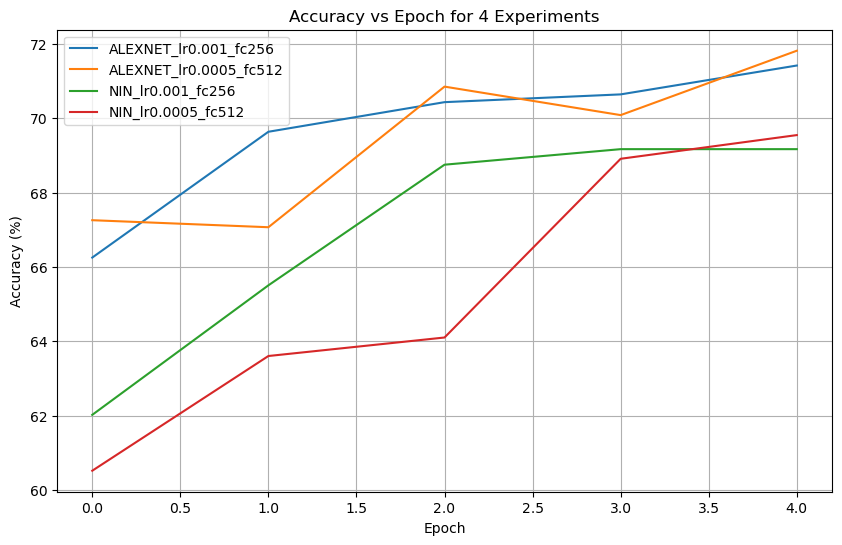

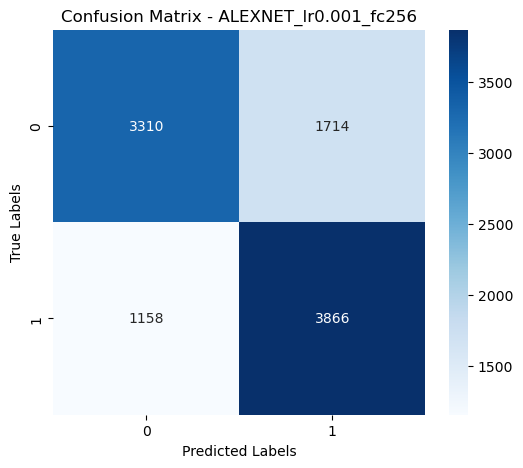

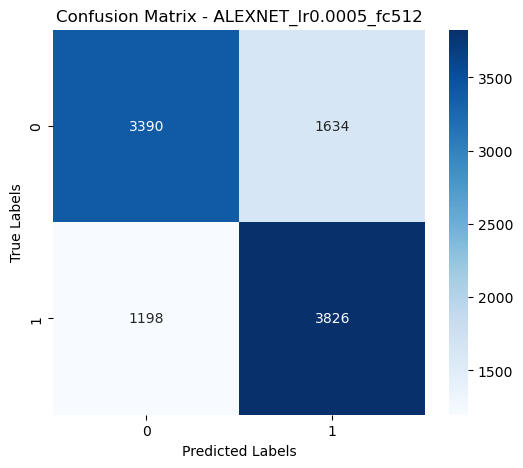

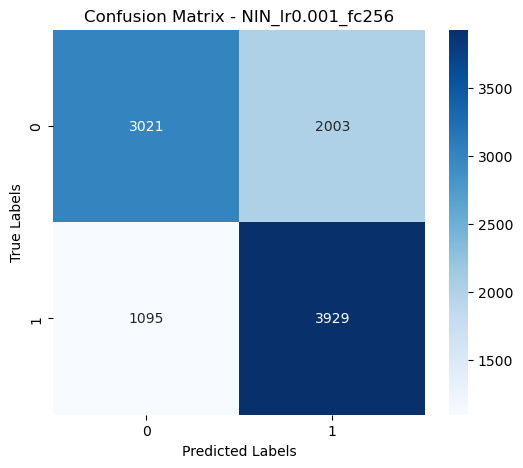

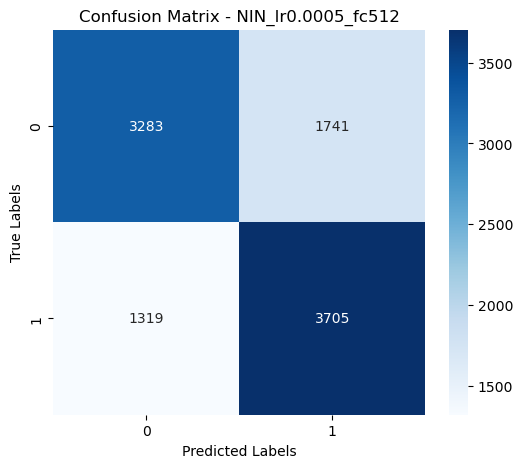

In [92]:
# Global Variables are defined at the top of the Notebook

def main():

    user_input = input("Do you wish to run the setup (y/n).")

    match user_input.lower():
        case 'n' | 'no':
            print("Skipping Setup ...")
        case 'y' | 'yes' | _:
            # Setup structure for files
            create_directories(DATA_DIR)
            copy_reference_genome(GENOME_SOURCE_DIR, GENOME_OUTPUT_DIR)
            download_files(DOWNLOAD_DIR)
            unzip_files(DOWNLOAD_DIR,POS_BED_FILE_DIR)
            convert_to_nucleotides(POS_BED_FILE_DIR, POS_TXT_DIR)

            # Find Optimal Length and Crop to said length
            opt_length = find_optimal_length(POS_BED_FILE_DIR)
            crop_sequences(POS_TXT_DIR, POS_NUCLEO_DIR, opt_length)

            # Create Negative Nucelotides and crop to Optimal Length
            create_negative_bed_files(POS_BED_FILE_DIR, NEG_BED_FILE_DIR)
            convert_to_nucleotides(NEG_BED_FILE_DIR, NEG_TXT_DIR)
            crop_sequences(NEG_TXT_DIR, NEG_NUCLEO_DIR, opt_length)

            # Adding Labels and Uppercase Sequences
            prepare_positive_file(POS_NUCLEO_FILE, C_POS_NUCLEO_FILE)
            prepare_negative_file(NEG_NUCLEO_FILE, C_NEG_NUCLEO_FILE)

            # Combing Positive and Negative Necleotides into one file
            interleave_merge_files(C_POS_NUCLEO_FILE, C_NEG_NUCLEO_FILE, MERGED_NUCLEO_FILE)


    # Load DNA sequences and their corresponding labels from the merged file
    seqs, labels = load_data(MERGED_NUCLEO_FILE)

    # Create a custom PyTorch dataset object from the sequences and labels
    dataset = DNADataset(seqs, labels)

    # Split the dataset into training and testing sets
    train_set, test_set = split_dataset(dataset)
    
    # Set up data loaders for batch processing during training and evaluation
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)   # Shuffle for training
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)    # No shuffle for testing

    # Initialize containers for storing models, results, and confusion matrix data
    models = []
    results = []
    confusion_data = []

    # Use GPU if available, otherwise fall back to CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if device.type=='cuda':
        print(torch.cuda.get_device_name(0))
        print(torch.cuda.mem_get_info())

    # Define the loss function (cross-entropy for classification tasks)
    loss_fn = nn.CrossEntropyLoss()

    # Each configuration tests different learning rates and fully connected layer sizes
    alexnet_configs = [
        {'lr': 0.001, 'fc_units': 256},     # First AlexNet setup
        {'lr': 0.0005, 'fc_units': 512}     # Second AlexNet setup
    ]

    nin_configs = [
        {'lr': 0.001, 'fc_units': 256},     # First NiN setup
        {'lr': 0.0005, 'fc_units': 512}     # Second NiN setup
    ]

    # Run experiments for AlexNet using both hyperparameter configurations
    for config in alexnet_configs:
        model = AlexNet(fc_units=config['fc_units']).to(device)             # Create model with specified FC units
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])   # Set up optimizer with config LR
        acc_per_epoch = []                                                  # Store accuracy over each epoch

        # Train and evaluate model for each epoch
        for epoch in range(1,EPOCHS + 1):
            train(model, device, train_loader, optimizer, epoch, loss_fn)
            acc, y_true, y_pred = test(model, device, test_loader, loss_fn, collect_preds=True)
            acc_per_epoch.append(acc)

        # Save accuracy results and final confusion matrix data
        results.append({
            'label': f'ALEXNET_lr{config["lr"]}_fc{config["fc_units"]}', 
            'acc': acc_per_epoch
        })
        models.append(model)
        confusion_data.append({
            'label': f'ALEXNET_lr{config["lr"]}_fc{config["fc_units"]}',
            'y_true': y_true,               # True labels from final epoch
            'y_pred': y_pred                # Predicted labels from final epoch       
        })


    # Repeat the same experimental procedure for the Program_2 (NiN-style) models
    for config in nin_configs:
        model = Program_2(fc_units=config['fc_units']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        acc_per_epoch = []

        for epoch in range(1,EPOCHS + 1):
            train(model, device, train_loader, optimizer, epoch, loss_fn)
            acc, y_true, y_pred = test(model, device, test_loader, loss_fn, collect_preds=True)
            acc_per_epoch.append(acc)

        results.append({
            'label': f'NIN_lr{config["lr"]}_fc{config["fc_units"]}', 
            'acc': acc_per_epoch
        })
        models.append(model)
        confusion_data.append({
            'label': f'NIN_lr{config["lr"]}_fc{config["fc_units"]}',
            'y_true': y_true,
            'y_pred': y_pred
        })

    # The accuracy vs epoch graph shows how each model’s performance evolved during training. Each line represents a different experiment, tracking accuracy after every epoch. 
    # This helps compare how fast each model learns, whether it overfits or underfits, and which hyperparameter setup ultimately performs best.
    plt.figure(figsize=(10, 6))
    for result in results:
        plt.plot(result['acc'], label=result['label'])

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epoch for 4 Experiments')
    plt.legend()
    plt.grid(True)
    plt.show()

    # The confusion matrix reflects how well the fully trained model performs on the test set, not how it did throughout training. That makes it a clean summary of each model’s end performance.
    for data in confusion_data:
        cm = confusion_matrix(data['y_true'], data['y_pred'], labels=[0, 1])

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.ylabel('True Labels')
        plt.xlabel('Predicted Labels')
        plt.title(f"Confusion Matrix - {data['label']}")
        plt.show()


if __name__ == "__main__":
    main()